In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [6]:
df=pd.read_csv('Sample-Superstore.csv', encoding='ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,06/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Câu 1: Doanh thu và lợi nhuận thay đổi như thế nào qua các năm?

In [7]:
# Sao lưu bản gốc để đối chiếu khi cần
df_raw = df.copy()

# Ép kiểu ngày (Order Date & Ship Date)
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date']  = pd.to_datetime(df['Ship Date'],  errors='coerce')

# Loại bỏ dòng không có ngày đặt hàng (Order Date)
df = df.dropna(subset=['Order Date'])

# Tạo thêm các cột phụ phục vụ cho phân tích
df['Order Year']  = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.to_period('M').astype(str)
df['Ship Days']   = (df['Ship Date'] - df['Order Date']).dt.days

# Loại bỏ dòng trùng lặp theo Order ID & Product ID
df = df.drop_duplicates(subset=['Order ID', 'Product ID'], keep='first')

# Xử lý giá trị lỗi trong Sales & Profit
# Giữ Profit âm (đơn hàng lỗ thật)
# Chỉ loại dòng bị thiếu hoặc có Sales <= 0 (vì bán âm là lỗi nhập liệu)
df = df[df['Sales'].notna() & (df['Sales'] > 0)]
df = df[df['Profit'].notna()]

# Tạo biến phụ: Profit Margin (%)
df['Profit_Margin'] = df['Profit'] / df['Sales']

display(df_raw.head())

# Lưu lại dataset nền cho các câu tiếp theo
df_clean_base = df.copy()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/08/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,06/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
# Tính Sales và Profit gộp theo từng năm:
kpi_year=df.groupby('Order Year').agg({'Sales':'sum','Profit':'sum'}).reset_index()

# Các chỉ số phụ:
# Biên lợi nhuận(Tỷ lệ lợi nhuận/doanh thu)
margin_profit=kpi_year['Profit']/kpi_year['Sales']
# Sự tăng trưởng Sales qua các năm
growth_sales=kpi_year['Sales'].pct_change()*100
# Sự tăng trưởng Profit qua các năm
growth_profit=kpi_year['Profit'].pct_change()*100

# Tạo bảng tổng hợp
kpi_extra = kpi_year.copy()
kpi_extra['Margin Profit'] = margin_profit
kpi_extra['Growth Sales'] = growth_sales
kpi_extra['Growth Profit'] = growth_profit

print("Doanh thu và lợi nhuận theo năm, biên lợi nhuận (tỉ lệ lợi nhuận/doanh thu), sự tăng trưởng của Sales và Profit qua từng năm là:")
display(kpi_extra)

Doanh thu và lợi nhuận theo năm, biên lợi nhuận (tỉ lệ lợi nhuận/doanh thu), sự tăng trưởng của Sales và Profit qua từng năm là:


,Order Year,Sales,Profit,Margin Profit,Growth Sales,Growth Profit
0,2014,483966.1261,49556.0329,0.102396,NaN,NaN
1,2015,470442.4490,61577.1761,0.130892,-2.794344,24.257679
2,2016,608532.4580,81613.2824,0.134115,29.353220,32.538203
3,2017,732568.5392,93267.3282,0.127315,20.382821,14.279595


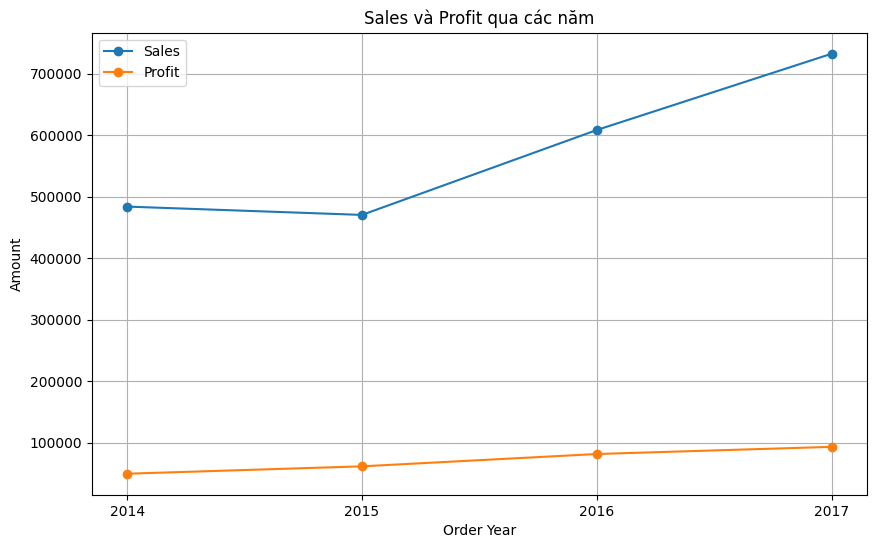

In [ ]:
# Vẽ biểu đồ đường (Sales, Profit) để thấy được sự tăng trưởng qua từng năm.
plt.figure(figsize=(10, 6))
plt.plot(kpi_extra['Order Year'], kpi_extra['Sales'], marker='o', linestyle='-', label='Sales')
plt.plot(kpi_extra['Order Year'], kpi_extra['Profit'], marker='o', linestyle='-', label='Profit')
plt.xlabel('Order Year')
plt.ylabel('Amount')
plt.title('Sales và Profit qua các năm')
plt.xticks(kpi_extra['Order Year'])
plt.grid(True)
plt.legend()
plt.show()

TỔNG QUAN:

Giai đoạn 2014–2017, doanh thu (Sales) và lợi nhuận (Profit) của doanh nghiệp đều tăng trưởng tích cực.
- Doanh thu tăng từ 483,966 USD (2014) lên 732,569 USD (2017), tương đương mức tăng khoảng +51%.
- Lợi nhuận tăng gần +88%, từ 49,556 USD lên 93,267 USD.
- Biên lợi nhuận duy trì quanh mức 10–13%, thể hiện khả năng sinh lời ổn định.

CHI TIẾT
1. Doanh thu (Sales)
- 2014 → 2015: Doanh thu giảm nhẹ -2.94%, cho thấy giai đoạn thị trường hoặc chiến lược bán hàng tạm chững.
- 2015 → 2016: Phục hồi mạnh, doanh thu tăng 29.35%, phản ánh hiệu quả của việc mở rộng sản phẩm hoặc khu vực kinh doanh.
- 2016 → 2017: Tiếp tục tăng 20.38%, củng cố xu hướng tăng trưởng bền vững.

==> Tổng thể, doanh thu tăng liên tục sau năm 2015, thể hiện khả năng mở rộng thị trường và duy trì sức mua của khách hàng.


2. Lợi nhuận (Profit)

- Tăng đều qua các năm: +24% (2015), +33% (2016), +14% (2017).
- Mức tăng lợi nhuận thường tỷ lệ thuận với doanh thu, chứng tỏ chi phí được kiểm soát tốt trong giai đoạn đầu.
- năm 2017 tốc độ tăng lợi nhuận thấp hơn tốc độ tăng doanh thu → có thể do gia tăng chiết khấu, chi phí vận chuyển, hoặc chi phí mở rộng hoạt động.


3. Biên lợi nhuận (Profit Margin)
- 2014 → 2016: Biên lợi nhuận cải thiện từ 10.24% lên 13.41%, phản ánh hiệu quả hoạt động ngày càng tốt.
- 2017: Giảm nhẹ còn 12.73%, cho thấy chi phí có dấu hiệu tăng trở lại, cần xem xét nguyên nhân (chiết khấu cao, giá vốn tăng…).

==> Dù giảm nhẹ, mức biên lợi nhuận >12% vẫn là mức tốt trong ngành bán lẻ tiêu dùng.

KẾT LUẬN:
- Doanh nghiệp tăng trưởng bền vững:
  + Doanh thu và lợi nhuận đều tăng qua các năm.
  + Giai đoạn 2015–2017 là thời kỳ phục hồi và mở rộng mạnh mẽ.
- Hiệu quả hoạt động ổn định:
  + Biên lợi nhuận duy trì quanh 12–13%, cho thấy chiến lược vận hành và giá vốn được kiểm soát tốt.
- Rủi ro tiềm ẩn:
  + Năm 2017, lợi nhuận tăng chậm hơn doanh thu → cần phân tích sâu chi phí (discount, shipping, marketing) để đảm bảo hiệu quả sinh lời.

- Đề xuất:
  + Kiểm tra chiết khấu trung bình năm 2017 và cấu trúc chi phí vận hành.
  + Phân tích nhóm sản phẩm hoặc khu vực sinh lợi kém để tối ưu danh mục.
  + Tận dụng xu hướng tăng trưởng 2016–2017 để dự báo và đặt mục tiêu cho năm 2018.

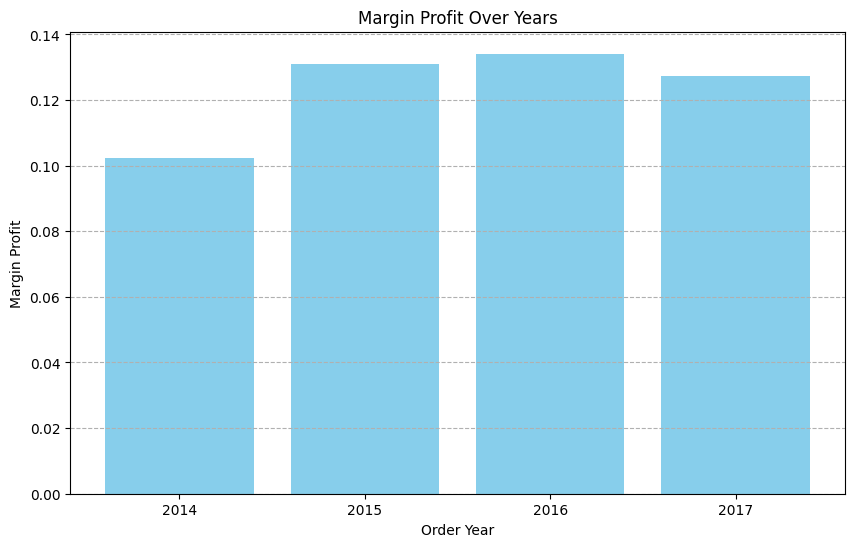

In [ ]:
# Vẽ biểu đồ cột cho Margin Profit qua các năm.
plt.figure(figsize=(10, 6))
plt.bar(kpi_extra['Order Year'], kpi_extra['Margin Profit'], color='skyblue')
plt.xlabel('Order Year')
plt.ylabel('Margin Profit')
plt.title('Margin Profit Over Years')
plt.xticks(kpi_extra['Order Year'])
plt.grid(axis='y', linestyle='--')
plt.show()

TỔNG QUAN:

Qua 4 năm, doanh nghiệp duy trì hiệu quả sinh lời ổn định, dao động trong khoảng 10%–13%, với xu hướng cải thiện rõ rệt giai đoạn đầu, sau đó ổn định nhẹ về cuối kỳ.

CHI TIẾT:

- 2014 → 2015: Biên lợi nhuận tăng mạnh từ 10.2% lên 13.1%, mức tăng khoảng +28% so với năm trước. Có thể doanh nghiệp đã tối ưu hóa chi phí hoặc tăng hiệu quả vận hành, ví dụ như cải thiện logistics, đàm phán tốt hơn với nhà cung cấp, hoặc tập trung vào sản phẩm lợi nhuận cao.
- 2015 → 2016: Biên lợi nhuận tiếp tục nhích lên 13.4%, đạt đỉnh cao nhất trong 4 năm. Đây có thể là giai đoạn doanh nghiệp vận hành hiệu quả nhất, đồng thời kiểm soát tốt chiết khấu và chi phí cố định.
- 2016 → 2017: Biên lợi nhuận giảm nhẹ xuống 12.7%, tuy vẫn duy trì ở mức cao. Dấu hiệu này cho thấy chi phí tăng hoặc chính sách chiết khấu mở rộng để kích cầu, làm giảm phần trăm lợi nhuận trên doanh thu.

KẾT LUẬN:
- Hiệu quả sinh lời được cải thiện rõ rệt sau năm 2014 và giữ ổn định quanh 13%, đây là dấu hiệu tích cực về quản lý chi phí và tối ưu vận hành.
- Năm 2017 cho thấy dấu hiệu giảm nhẹ biên lợi nhuận, cần kiểm tra nguyên nhân:
  + Gia tăng chiết khấu để đẩy mạnh doanh số.
  + Tăng chi phí logistics, marketing hoặc mở rộng thị trường.

==>Tổng thể, biên lợi nhuận ổn định >12% chứng minh doanh nghiệp đang vận hành hiệu quả và có nền tảng tài chính lành mạnh.

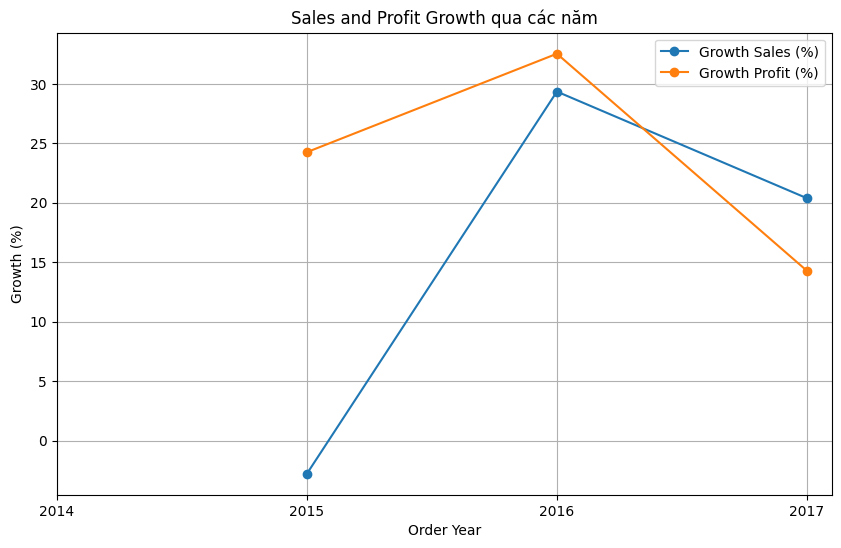

In [ ]:
# Vẽ biểu đồ đường (Growth Sales và Growth Profit).
plt.figure(figsize=(10, 6))
plt.plot(kpi_extra['Order Year'], kpi_extra['Growth Sales'], marker='o', linestyle='-', label='Growth Sales (%)')
plt.plot(kpi_extra['Order Year'], kpi_extra['Growth Profit'], marker='o', linestyle='-', label='Growth Profit (%)')
plt.xlabel('Order Year')
plt.ylabel('Growth (%)')
plt.title('Sales and Profit Growth qua các năm')
plt.xticks(kpi_extra['Order Year'])
plt.grid(True)
plt.legend()
plt.show()

TỔNG QUAN:

Biểu đồ “Sales and Profit Growth qua các năm” cho thấy tốc độ tăng trưởng (%) theo năm của cả doanh thu và lợi nhuận.
- Giai đoạn 2014 - 2015: doanh thu sụt giảm nhẹ, nhưng lợi nhuận vẫn tăng.
- Giai đoạn 2015 - 2016: cả hai chỉ số đều bứt phá mạnh, đạt đỉnh tăng trưởng.
- Giai đoạn 2016 - 2017: tốc độ tăng trưởng giảm nhẹ nhưng vẫn duy trì dương, thể hiện sự ổn định sau giai đoạn tăng nhanh.

CHI TIẾT:

- 2014 → 2015: Dù doanh thu giảm nhẹ gần 3%, lợi nhuận lại tăng 24%, chứng tỏ công ty đã cắt giảm chi phí hoặc tập trung vào sản phẩm có biên lợi nhuận cao hơn. Đây là giai đoạn nâng cao hiệu quả hơn là mở rộng thị trường.
- 2015 → 2016: Bùng nổ doanh thu và lợi nhuận cho thấy sự thành công trong chiến lược mở rộng hoặc hiệu quả đầu tư trước đó. Doanh thu tăng mạnh 29%, lợi nhuận tăng 33% — cả hai đều đạt mức cao nhất trong chuỗi 4 năm.
- 2016 → 2017:Tốc độ tăng trưởng chậm lại: Sales tăng 20%, Profit tăng 14%. Có thể do chi phí vận hành, marketing, hoặc chiết khấu tăng, làm giảm biên lợi nhuận. Tuy vậy, duy trì mức tăng trưởng dương cho thấy doanh nghiệp vẫn giữ đà tăng ổn định.

KẾT LUẬN:
- Hiệu suất hoạt động được cải thiện rõ rệt: Năm 2015 là minh chứng khi lợi nhuận tăng dù doanh thu giảm.
- Tăng trưởng bền vững: Sau năm 2016 đạt đỉnh, công ty vẫn giữ đà tăng, không sụt giảm mạnh.
- Chi phí cần được kiểm soát: 2017 cho thấy tốc độ tăng lợi nhuận thấp hơn doanh thu — dấu hiệu cần xem xét hiệu quả mở rộng hoặc chính sách chiết khấu.
- Giai đoạn 2015-2016 là bước ngoặt, từ tái cấu trúc sang tăng trưởng mạnh — có thể xem là thời kỳ “chuyển hóa chiến lược”.

Câu 2: Nhóm sản phẩm nào mang lại lợi nhuận cao nhất?

In [ ]:
# Clean data
df_clean_prod=df_clean_base.copy()

# Loại bỏ dòng trống trong 2 cột Category và Sub-Category:
df_clean_prod = df_clean_prod.dropna(subset=['Category', 'Sub-Category'])

# Loại bỏ khoảng trắng và chuẩn hóa viết hoa 2 cột Category và Sub-Category:
df_clean_prod['Category'] = df_clean_prod['Category'].str.strip().str.title()
df_clean_prod['Sub-Category'] = df_clean_prod['Sub-Category'].str.strip().str.title()

# Tính Profit Margin:
df_clean_prod['Profit_Margin'] = df_clean_prod['Profit'] / df_clean_prod['Sales']

In [ ]:
# Triển khai:
# Tính Sales và Profit gộp theo Category và Sub-Category
kpi_prod=df_clean_prod.groupby(['Category', 'Sub-Category'])[['Sales', 'Profit']].sum().sort_values(['Profit'], ascending=False).reset_index()
# Thêm chỉ tiêu hiệu quả(%):
kpi_prod['margin_profit']=kpi_prod['Profit']/kpi_prod['Sales']*100

display(kpi_prod.head(10))

,Category,Sub-Category,Sales,Profit,margin_profit
0,Technology,Copiers,149528.030,55617.8249,37.195585
1,Technology,Phones,330007.054,44515.7306,13.489327
2,Technology,Accessories,166986.022,41867.8220,25.072651
3,Office Supplies,Paper,78384.406,34009.4701,43.388056
4,Office Supplies,Binders,203322.673,30180.3357,14.843566
5,Furniture,Chairs,328167.731,26602.2251,8.106289
6,Office Supplies,Storage,223299.228,21120.9562,9.458589
7,Office Supplies,Appliances,107532.161,18138.0054,16.867517
8,Furniture,Furnishings,91418.784,12976.0934,14.194122
9,Office Supplies,Envelopes,16476.402,6964.1767,42.267582


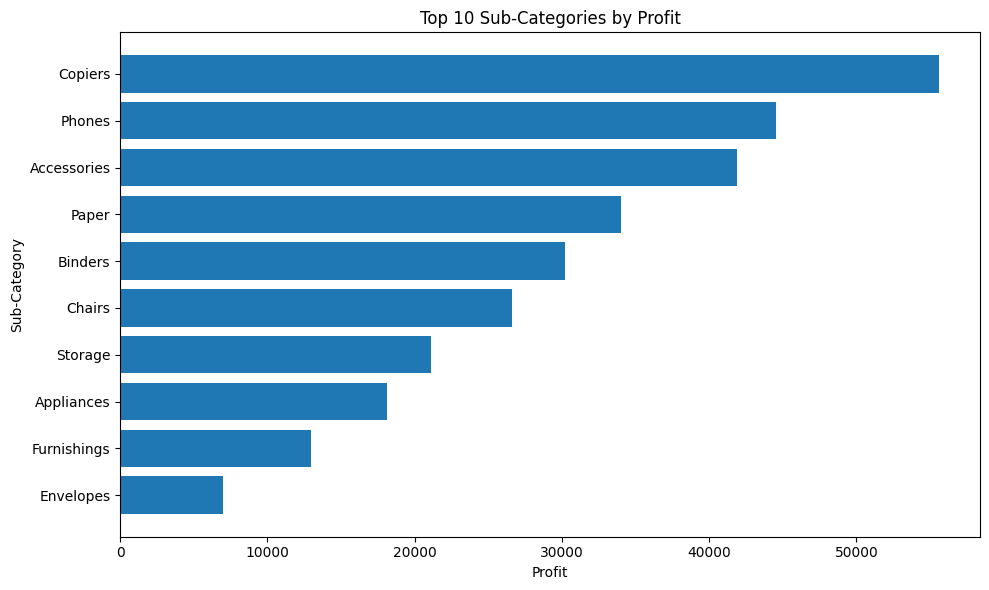

In [ ]:
# Vẽ  biểu đồ cột Top 10 nhóm sản phẩm (Sub-Category) mang lại lợi nhuận cao nhất
plt.figure(figsize=(10,6))
plt.barh(kpi_prod['Sub-Category'].head(10), kpi_prod['Profit'].head(10))
plt.gca().invert_yaxis()
plt.title("Top 10 Sub-Categories by Profit")
plt.xlabel("Profit")
plt.ylabel("Sub-Category")
plt.tight_layout()
plt.show()

TỔNG QUAN:
- Biểu đồ trên thể hiện 10 nhóm sản phẩm con (Sub-Category) có lợi nhuận cao nhất trong toàn bộ doanh nghiệp.
- Kết quả cho thấy “Copiers” (máy photocopy) là nhóm sản phẩm sinh lợi nhuận cao nhất, vượt trội hơn hẳn so với các nhóm khác. Theo sau là Phones (điện thoại), Accessories (phụ kiện), và Paper (giấy văn phòng).

CHI TIẾT:
- Các nhóm Công nghệ (Copiers, Phones, Accessories) chiếm 3/10 nhóm đầu bảng, chứng tỏ ngành hàng công nghệ là trụ cột lợi nhuận của doanh nghiệp.
- Các nhóm Văn phòng phẩm (Paper, Binders, Envelopes) vẫn có lợi nhuận ổn định nhưng biên lợi nhuận thấp hơn, do giá bán thấp và tính cạnh tranh cao.
- Nhóm Nội thất (Chairs, Furnishings) có biên lợi nhuận thấp hơn kỳ vọng — có thể do chi phí vận chuyển hoặc tồn kho cao.

KẾT LUẬN:
- Nhóm sản phẩm sinh lợi cao nhất: Copiers (máy photocopy) là nguồn lợi nhuận lớn nhất, thể hiện hiệu quả kinh doanh vượt trội và biên lợi nhuận cao.
- Các nhóm phụ trợ mạnh: Phones và Accessories cũng đóng vai trò động lực tăng trưởng lợi nhuận quan trọng.
- Cả ba nhóm này đều thuộc Category “Technology”, khẳng định công nghệ là mảng kinh doanh chiến lược.
- Chiến lược đề xuất:
  + Tập trung mở rộng danh mục sản phẩm công nghệ (đặc biệt là Copiers và Phones).
  + Duy trì nhóm văn phòng phẩm để ổn định doanh thu, nhưng cải thiện biên lợi nhuận bằng tối ưu chi phí và đàm phán nhà cung cấp.
  + Phân tích sâu thêm nhóm nội thất (Furniture) để xác định nguyên nhân lợi nhuận thấp và cơ hội cải thiện giá trị.

Câu 3: Top 10 thành phố có hiệu suất kinh doanh tốt nhất?

In [ ]:
# Kế thừa data clean từ câu 2:
df_clean_region=df_clean_prod.copy()

# Loại bỏ dòng trống các giá trị ở cột City, State, Region:
df_clean_region = df_clean_region.dropna(subset=['City', 'State', 'Region'])

# Loại bỏ khoảng trắng, chuẩn hóa viết hoa cột City, State, Region:
df_clean_region['City'] = df_clean_region['City'].str.strip().str.title()
df_clean_region['State'] = df_clean_region['State'].str.strip().str.title()
df_clean_region['Region'] = df_clean_region['Region'].str.strip().str.title()

In [ ]:
# Triển khai:
region_profit=df_clean_region.groupby(['Region','State','City'])[['Sales','Profit']].sum().reset_index().sort_values(['Profit'], ascending=False)
display(region_profit.head(10))

,Region,State,City,Sales,Profit
253,East,New York,New York City,256319.041,62013.8973
480,West,California,Los Angeles,175851.341,30440.7579
600,West,Washington,Seattle,119540.742,29156.0967
507,West,California,San Francisco,112669.092,17507.3854
65,Central,Michigan,Detroit,42446.944,13181.7908
39,Central,Indiana,Lafayette,19630.450,8976.0973
197,East,Delaware,Newark,20448.050,8086.1715
354,South,Georgia,Atlanta,17197.840,6993.6629
88,Central,Minnesota,Minneapolis,16870.540,6824.5846
506,West,California,San Diego,47521.029,6377.1960


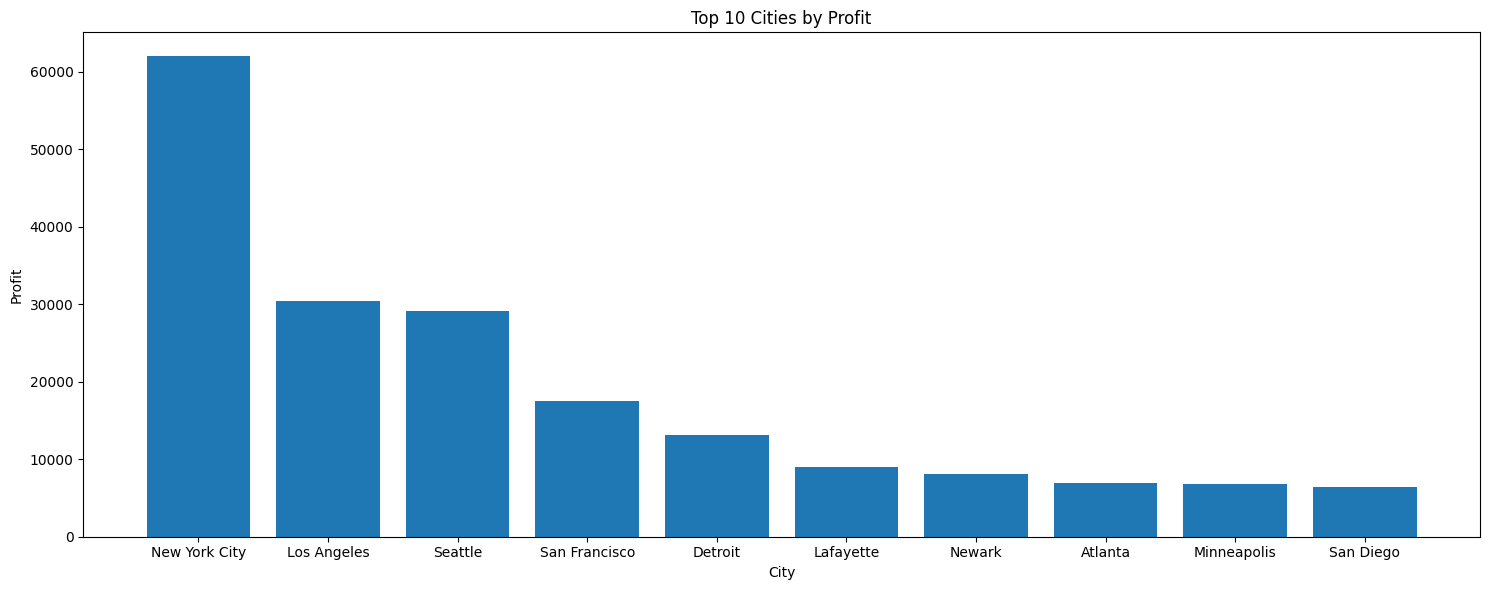

In [ ]:
# Vẽ biểu đồ cột giữa City và Profit
plt.figure(figsize=(15, 6))
plt.bar(region_profit['City'].head(10), region_profit['Profit'].head(10))
plt.xlabel('City')
plt.ylabel('Profit')
plt.title('Top 10 Cities by Profit')
plt.tight_layout()
plt.show()

TỔNG QUAN:

Biểu đồ và bảng dữ liệu cho thấy hiệu suất kinh doanh theo thành phố, được đo bằng tổng lợi nhuận (Profit):
- Trong đó, New York City nổi bật với hiệu suất vượt trội, mang lại mức lợi nhuận cao gần gấp đôi thành phố đứng thứ hai (Los Angeles).
- Phần lớn các thành phố sinh lợi cao thuộc khu vực ven biển (East & West Region) - là các trung tâm kinh tế, dân cư đông và sức mua mạnh.

CHI TIẾT:
- Top 3 thành phố sinh lợi tốt nhất: New York City, Los Angeles, và Seattle.
Đây là trung tâm kinh tế lớn, có lưu lượng đơn hàng và sức mua cao, đóng vai trò đầu tàu trong lợi nhuận tổng thể.

- Phân bố vùng:
  + West Region chiếm gần 50% trong Top 10, phản ánh hiệu suất mạnh mẽ của khu vực bờ Tây (California, Washington).
  + East Region có ít thành phố nhưng đóng góp lợi nhuận rất cao, đặc biệt là New York.

- Đặc điểm đáng chú ý:
  + Một số thành phố quy mô nhỏ (Lafayette, Newark Minneapolis) tuy doanh thu thấp nhưng lợi nhuận cao — chứng tỏ chi phí vận hành thấp, hiệu quả tốt.
  + San Diego là trường hợp đáng chú ý: doanh thu khá cao nhưng lợi nhuận thấp hơn kỳ vọng, có thể do chi phí thuê mặt bằng hoặc logistics cao.

KẾT LUẬN:
- Tập trung đầu tư mở rộng tại các thị trường New York, Los Angeles, Seattle
- Phân tích chi tiết chi phí tại San Diego để xác định nguyên nhân lợi nhuận thấp.
- Nhân rộng mô hình vận hành của các thành phố nhỏ có hiệu suất cao (như Lafayette hoặc Newark).

Câu 4: Giảm giá ảnh hưởng như thế nào đến lợi nhuận (Profit Margin)?

In [ ]:
# Kế thừa lại Data từ câu 3
df_clean_discount=df_clean_region.copy()

# Loại bỏ những dòng bị thiểu ở cột Discount.
df_clean_discount = df_clean_discount.dropna(subset=['Discount'])
df_clean_discount = df_clean_discount[df_clean_discount['Discount'] >= 0]

# Kiểm tra hợp lý cho Discount (Loại Discount >= 1)
df_clean_discount = df_clean_discount[df_clean_discount['Discount']<=1]

display(df_clean_discount)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Order Year,Order Month,Ship Days,Profit_Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,2016-11,3,0.1600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,2016-11,3,0.3000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,2016-06,4,0.4700
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,2015-10,7,-0.4000
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,2015-10,7,0.1125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9990,CA-2014-110422,2014-01-21,2014-01-23,Second Class,TB-21400,Tom Boeckenhauer,Consumer,United States,Miami,...,Furnishings,Ultra Door Pull Handle,25.2480,3,0.20,4.1028,2014,2014-01,2,0.1625
9990,9991,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,Furnishings,Tenex B1-RE Series Chair Mats for Low Pile Car...,91.9600,2,0.00,15.6332,2017,2017-02,5,0.1700
9991,9992,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,Phones,Aastra 57i VoIP phone,258.5760,2,0.20,19.3932,2017,2017-02,5,0.0750
9992,9993,CA-2017-121258,2017-02-26,2017-03-03,Standard Class,DB-13060,Dave Brooks,Consumer,United States,Costa Mesa,...,Paper,"It's Hot Message Books with Stickers, 2 3/4"" x 5""",29.6000,4,0.00,13.3200,2017,2017-02,5,0.4500


In [ ]:
# Thống kê mô tả dữ liệu:
desc_discount = df_clean_discount[['Discount','Profit_Margin']].describe()
print("Thống kê mô tả Discount và Profit Margin:")
display(desc_discount)

Thống kê mô tả Discount và Profit Margin:


,Discount,Profit_Margin
count,9986.000000,9986.000000
mean,0.156258,0.120185
std,0.206499,0.466894
min,0.000000,-2.750000
25%,0.000000,0.075000
50%,0.200000,0.270000
75%,0.200000,0.362500
max,0.800000,0.500000


In [ ]:
# Tính hệ số tương quan giữa Discount và Profit_Margin
corr = df_clean_discount['Discount'].corr(df_clean_discount['Profit_Margin'])
print(f'Hệ số tương quan giữa Discount và Profit_Margin: {corr:3f}')

# Label cho kết quả của hệ số tương quan giữa Discount và Profit_Margin:
if corr < -0.5:
  print('--> Hệ số tương quan âm mạnh: Giảm giá càng cao thì lợi nhuận biên càng thấp một cách rõ rệt.')
elif corr < -0.3:
  print('--> Hệ số tương quan âm vừa: Giảm giá cao thường làm giảm biên lợi nhuận.')
elif corr < 0:
  print('--> Hệ số tương quan có sự âm nhẹ: Giảm giá nhiều thì sẽ giảm biên lợi nhuận, nhưng có thể kích thích mua sắm')
elif corr > 0:
  print('--> Hệ số tương quan dương: Giảm giá nhiều thì sẽ tăng biên lợi nhuận.')
else:
  print('Không có mối liên hệ nào ở đây cả')

Hệ số tương quan giữa Discount và Profit_Margin: -0.864446
--> Hệ số tương quan âm mạnh: Giảm giá càng cao thì lợi nhuận biên càng thấp một cách rõ rệt.


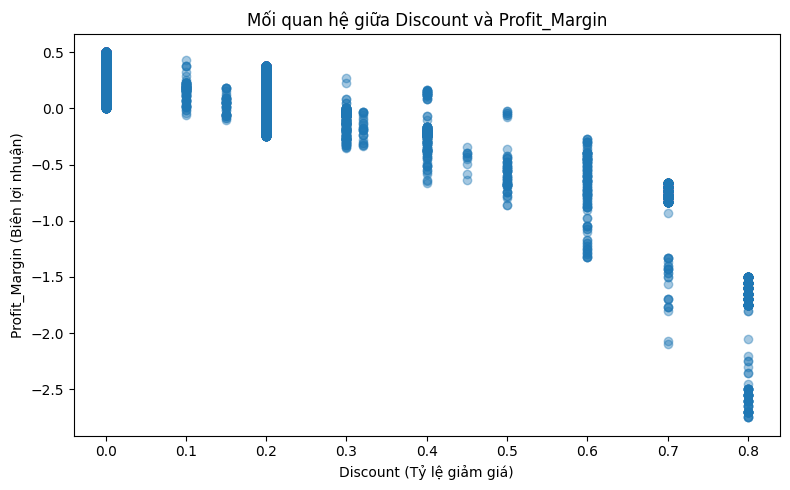

In [ ]:
# Vẽ biểu đồ sự tương quan của Discount và Profit_Margin
plt.figure (figsize=(8,5))
plt.scatter(df_clean_discount['Discount'], df_clean_discount['Profit_Margin'], alpha=0.4)
plt.title('Mối quan hệ giữa Discount và Profit_Margin')
plt.xlabel('Discount (Tỷ lệ giảm giá)')
plt.ylabel('Profit_Margin (Biên lợi nhuận)')
plt.tight_layout()
plt.show()

TỔNG QUAN:

Kết quả cho thấy tác động tiêu cực rõ rệt: khi tỷ lệ giảm giá tăng, biên lợi nhuận giảm mạnh và thậm chí có thể âm — tức là công ty bán lỗ ở những đơn hàng có chiết khấu cao.

CHI TIẾT:
- Biểu đồ thể hiện rõ mối quan hệ nghịch biến giữa hai biến:
  + Khi Discount = 0: Profit Margin dương cao (khoảng 0.2-0.5) → bán hàng không giảm giá mang lại lợi nhuận tốt.
  + Khi Discount tăng lên 0.2-0.4: Profit Margin giảm mạnh, nhiều điểm gần bằng 0 hoặc âm nhẹ.
  + Khi Discount vượt 0.5 (giảm giá 50% trở lên): Profit Margin âm, tức doanh nghiệp bị lỗ.

==> Giảm giá càng nhiều thì biên lợi nhuận càng giảm, và có thể chuyển sang thua lỗ khi mức chiết khấu quá cao.

KẾT LUẬN:
- Quan hệ giữa Discount và Profit Margin là nghịch biến:
  + Khi tăng giảm giá để kích cầu, doanh nghiệp phải chấp nhận biên lợi nhuận giảm.
  + Nếu vượt ngưỡng khoảng 40-50%, khả năng bán lỗ là rất cao.
- Chiến lược giá cần kiểm soát ngưỡng chiết khấu:
  + Nên đặt ngưỡng trần giảm giá hợp lý (<30%), đảm bảo không ảnh hưởng nghiêm trọng đến lợi nhuận.
  + Chỉ áp dụng mức giảm sâu cho sản phẩm tồn kho hoặc nhóm lợi nhuận cao (Copiers, Phones) để vẫn giữ biên dương.

Câu 5: Ship Mode ảnh hưởng đến lợi nhuận / thời gian giao hàng?

In [ ]:
# Kế thừa dataset từ Câu 5
df_clean_ship = df_clean_discount.copy()

# Loại bỏ dòng thiếu hoặc trống Ship Mode
df_clean_ship = df_clean_ship.dropna(subset=['Ship Mode'])
df_clean_ship = df_clean_ship[df_clean_ship['Ship Mode'].astype(str).str.strip() != '']

# Chuẩn hóa chữ (bỏ khoảng trắng, viết hoa đầu từ)
df_clean_ship['Ship Mode'] = df_clean_ship['Ship Mode'].astype(str).str.strip().str.title()

# Kiểm tra thời gian giao hàng (Ship Days)
if 'Ship Days' not in df_clean_ship.columns:
    df_clean_ship['Ship Date'] = pd.to_datetime(df_clean_ship['Ship Date'], errors='coerce')
    df_clean_ship['Order Date'] = pd.to_datetime(df_clean_ship['Order Date'], errors='coerce')
    df_clean_ship['Ship Days'] = (df_clean_ship['Ship Date'] - df_clean_ship['Order Date']).dt.days

# Loại bỏ các giá trị Ship Days âm hoặc quá lớn (do nhập sai)
df_clean_ship = df_clean_ship[(df_clean_ship['Ship Days'] >= 0) & (df_clean_ship['Ship Days'] <= 30)]

In [ ]:
# Gom nhóm theo Ship Mode
ship_kpi = (
    df_clean_ship.groupby('Ship Mode')[['Sales', 'Profit', 'Ship Days']]
      .agg({'Sales':'sum', 'Profit':'sum', 'Ship Days':'mean'})
      .reset_index()
)

# Tính thêm Profit Margin (%)
ship_kpi['Profit_Margin_%'] = ship_kpi['Profit'] / ship_kpi['Sales'] * 100

# Hiển thị kết quả
print("📊 Hiệu quả theo phương thức giao hàng:")
display(ship_kpi.round(2))

📊 Hiệu quả theo phương thức giao hàng:


,Ship Mode,Sales,Profit,Ship Days,Profit_Margin_%
0,First Class,351379.30,48946.75,2.18,13.93
1,Same Day,128363.12,15891.76,0.04,12.38
2,Second Class,458260.47,57191.64,3.24,12.48
3,Standard Class,1357506.67,163983.66,5.01,12.08


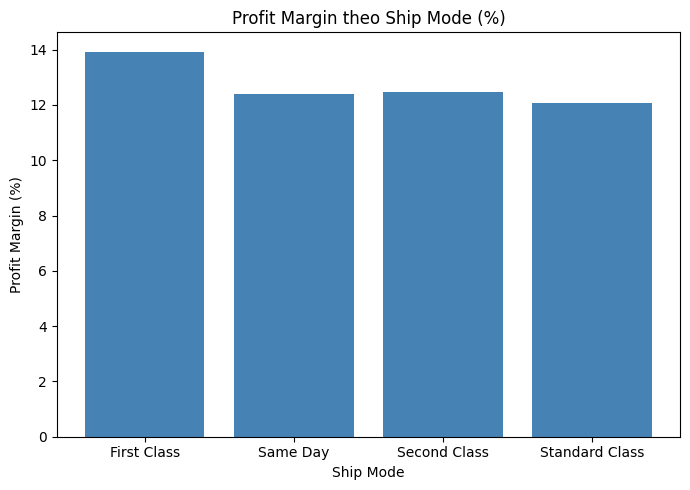

In [ ]:
# Vẽ biểu đồ cột giữa Profit Margin và Ship Mode
plt.figure(figsize=(7,5))
plt.bar(ship_kpi['Ship Mode'], ship_kpi['Profit_Margin_%'], color='steelblue')
plt.title("Profit Margin theo Ship Mode (%)")
plt.xlabel("Ship Mode")
plt.ylabel("Profit Margin (%)")
plt.tight_layout()
plt.show()

TỔNG QUAN:

Mối quan hệ giữa phương thức giao hàng (Ship Mode) với hiệu quả lợi nhuận (Profit Margin) và thời gian giao hàng (Ship Days):
- Phương thức First Class mang lại biên lợi nhuận cao nhất (13.93%).
- Trong khi Standard Class có biên lợi nhuận thấp nhất (12.08%) nhưng chiếm tỷ trọng doanh thu lớn nhất.
- Thời gian giao hàng càng nhanh thì chi phí tăng, song lợi nhuận biên không giảm đáng kể, cho thấy hiệu quả vận hành tốt ở các dịch vụ cao cấp.

CHI TIẾT:

Về lợi nhuận (Profit Margin):
- Mức chênh lệch biên lợi nhuận giữa các loại Ship Mode không quá lớn (khoảng2%),nhưng dịch vụ cao cấp (First Class) vẫn đem lại hiệu quả tốt nhất.
- Điều này cho thấy doanh nghiệp đã định giá hợp lý phí vận chuyển, không để chi phí giao nhanh làm giảm lợi nhuận đáng kể.

Về thời gian giao hàng (Ship Days):
- Giao càng nhanh → chi phí tăng → biên lợi nhuận có xu hướng giảm nhẹ.
- Tuy nhiên, dịch vụ Same Day (0.04 ngày) vẫn duy trì lợi nhuận dương (~12.38%), chứng tỏ hệ thống vận chuyển hiệu quả.

Về doanh thu (Sales):
- Standard Class chiếm doanh thu lớn nhất (khoảng 60% tổng sales), dù biên lợi nhuận thấp hơn.
- First Class và Second Class phù hợp cho khách hàng doanh nghiệp hoặc đơn hàng gấp, mang lại lợi nhuận cao hơn trên mỗi giao dịch.

KẾT LUẬN
- Ship Mode có ảnh hưởng rõ đến lợi nhuận và thời gian giao hàng.
  + Dịch vụ càng nhanh → chi phí vận chuyển cao → lợi nhuận biên giảm nhẹ.
  + Tuy nhiên, doanh nghiệp vẫn duy trì lợi nhuận dương trên mọi hình thức, cho thấy cấu trúc giá vận chuyển hợp lý.
- First Class là hình thức tối ưu nhất:
  + Cân bằng giữa tốc độ giao hàng (2.18 ngày) và biên lợi nhuận cao nhất (13.93%).
  + Thích hợp để đẩy mạnh cho khách hàng yêu cầu giao nhanh nhưng sẵn sàng trả phí cao hơn.
- Standard Class là “xương sống” doanh thu: Chiếm tỷ trọng doanh số lớn nhất → cần duy trì ổn định và đảm bảo chất lượng giao hàng để giữ khách hàng phổ thông.

In [ ]:
# Tính hệ số tương quan giữa Ship Day và Profit Margin
corr_ship = df_clean_ship['Ship Days'].corr(df_clean_ship['Profit_Margin'])
print(f"Hệ số tương quan giữa thời gian giao hàng và biên lợi nhuận: {corr_ship:.3f}")

if corr_ship < -0.3:
    print("Giao hàng càng nhanh thì lợi nhuận biên càng thấp (do chi phí cao).")
elif corr_ship > 0.3:
    print("Giao hàng chậm hơn lại mang lợi nhuận cao hơn (ngược kỳ vọng).")
else:
    print("Không có mối liên hệ mạnh giữa thời gian giao hàng và lợi nhuận.")

Hệ số tương quan giữa thời gian giao hàng và biên lợi nhuận: -0.012
Không có mối liên hệ mạnh giữa thời gian giao hàng và lợi nhuận.


Câu 6: Thời gian giao hàng trung bình mỗi Ship Mode là bao nhiêu?

In [ ]:
# Kế thừa dataset sạch từ câu 5
df_ship_time = df_clean_ship.copy()

# Đảm bảo cột Ship Days tồn tại và không có giá trị âm
df_ship_time = df_ship_time.dropna(subset=['Ship Days'])
df_ship_time = df_ship_time[df_ship_time['Ship Days'] >= 0]

In [ ]:
# Gom nhóm theo Ship Mode
ship_time_summary = (
    df_ship_time.groupby('Ship Mode')[['Ship Days']]
      .agg(['mean', 'median', 'min', 'max'])
      .reset_index()
)
# Làm gọn tên cột
ship_time_summary.columns = ['Ship Mode', 'Mean_Days', 'Median_Days', 'Min_Days', 'Max_Days']

# Hiển thị kết quả
print("Thời gian giao hàng trung bình theo Ship Mode:")
display(ship_time_summary.round(2))

Thời gian giao hàng trung bình theo Ship Mode:


,Ship Mode,Mean_Days,Median_Days,Min_Days,Max_Days
0,First Class,2.18,2.0,1,4
1,Same Day,0.04,0.0,0,1
2,Second Class,3.24,3.0,1,5
3,Standard Class,5.01,5.0,3,7


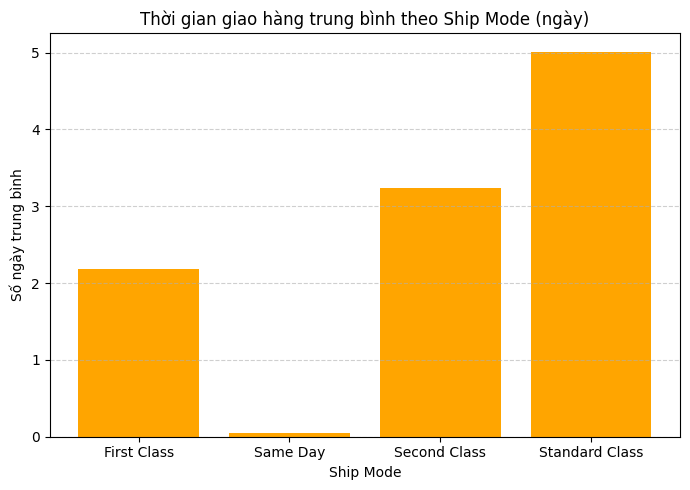

In [ ]:
# Vẽ biểu đồ thời gian giao hàng trung bình theo Ship Mode
plt.figure(figsize=(7,5))
plt.bar(ship_time_summary['Ship Mode'], ship_time_summary['Mean_Days'], color='orange')
plt.title("Thời gian giao hàng trung bình theo Ship Mode (ngày)")
plt.xlabel("Ship Mode")
plt.ylabel("Số ngày trung bình")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

TỔNG QUAN:

Thời gian giao hàng trung bình (Mean Days), trung vị (Median), và khoảng giao hàng (Min–Max) cho từng loại Ship Mode: mỗi hình thức giao hàng có tốc độ khác biệt rõ rệt, phản ánh chiến lược phục vụ đa phân khúc khách hàng (nhanh – tiêu chuẩn – tiết kiệm chi phí).

CHI TIẾT:

Cấu trúc thời gian giao hàng hợp lý:
- Các phương thức giao hàng được phân tầng rõ ràng theo tốc độ: Same Day → First Class → Second Class → Standard Class.
- Sự khác biệt này giúp doanh nghiệp đáp ứng đa dạng nhu cầu khách hàng.

Độ ổn định cao:
- Khoảng dao động giữa Min – Max tương đối nhỏ dẫn đến hệ thống giao vận hoạt động ổn định và đáng tin cậy.

Cân bằng giữa chi phí – tốc độ – lợi nhuận:
- Kết hợp với kết quả ở Câu 5, thấy rằng First Class đạt cả lợi nhuận cao và tốc độ nhanh cho thấy đây là phân khúc giao hàng tối ưu nhất.
- Standard Class tuy chậm nhưng vẫn giữ tỷ trọng doanh thu lớn, phù hợp cho các đơn hàng không gấp.

KẾT LUẬN:

- Hệ thống giao hàng có khả năng phục vụ đa tầng tốc độ, đáp ứng tốt cả nhóm khách hàng cần nhanh và nhóm tiết kiệm chi phí.
- Hiệu suất giao hàng ổn định, không có độ trễ bất thường, cho thấy khả năng quản lý logistics hiệu quả.

Câu 7: Phân khúc nào mang lại nhiều doanh thu và lợi nhuận nhất?



In [ ]:
# Kế thừa dataset từ câu 7
df_clean_segment = df_ship_time.copy()

# Loại bỏ dòng thiếu hoặc trống Segment
df_clean_segment = df_clean_segment.dropna(subset=['Segment'])
df_clean_segment = df_clean_segment[df_clean_segment['Segment'].astype(str).str.strip() != '']

# Chuẩn hóa chữ (bỏ khoảng trắng, viết hoa đầu từ)
df_clean_segment['Segment'] = df_clean_segment['Segment'].astype(str).str.strip().str.title()

In [ ]:
# Gom nhóm theo Segment
segment_kpi = (
    df_clean_segment.groupby('Segment')[['Sales', 'Profit']]
      .sum()
      .sort_values('Profit', ascending=False)
      .reset_index()
)
# Tính thêm chỉ tiêu hiệu quả
segment_kpi['Profit_Margin_%'] = segment_kpi['Profit'] / segment_kpi['Sales'] * 100

# Hiển thị kết quả
print("Doanh thu và lợi nhuận theo phân khúc khách hàng:")
display(segment_kpi.round(2))

Doanh thu và lợi nhuận theo phân khúc khách hàng:


,Segment,Sales,Profit,Profit_Margin_%
0,Consumer,1161012.63,134022.09,11.54
1,Corporate,705601.99,91821.26,13.01
2,Home Office,428894.96,60170.47,14.03


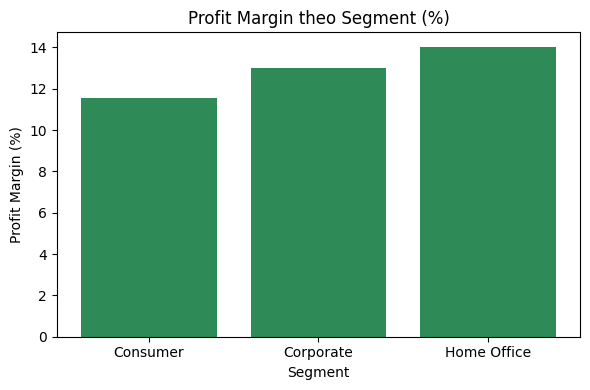

In [ ]:
# Vẽ biểu đồ Profit Margin theo Segment
plt.figure(figsize=(6,4))
plt.bar(segment_kpi['Segment'], segment_kpi['Profit_Margin_%'], color='seagreen')
plt.title("Profit Margin theo Segment (%)")
plt.xlabel("Segment")
plt.ylabel("Profit Margin (%)")
plt.tight_layout()
plt.show()


TỔNG QUAN:

Xác định phân khúc khách hàng (Segment) đóng góp doanh thu (Sales) và lợi nhuận (Profit) cao nhất, đồng thời so sánh biên lợi nhuận (Profit Margin) giữa các nhóm và kết quả cho thấy:
- Consumer là phân khúc doanh thu lớn nhất.
- Home Office tuy doanh thu thấp hơn, nhưng có biên lợi nhuận cao nhất.
- Corporate nằm giữa hai nhóm, cân bằng tốt giữa doanh thu và lợi nhuận.

CHI TIẾT:
- Consumer là trụ cột doanh thu, chiếm hơn khoảng 50% tổng doanh thu, nhưng biên lợi nhuận bị ảnh hưởng do chiết khấu và khối lượng bán lẻ lớn.
- Corporate là phân khúc cân bằng, đóng góp khoảng 30% doanh thu và lợi nhuận ổn định.
- Home Office là phân khúc sinh lời cao nhất nhờ biên lợi nhuận vượt trội (khoảng 14%), thích hợp cho chiến lược lợi nhuận tối đa.

KẾT LUẬN:
- Phân khúc mang lại doanh thu cao nhất: Consumer – chiếm khoảng một nửa tổng doanh thu toàn hệ thống, là nguồn doanh thu chủ lực.
- Phân khúc mang lại lợi nhuận cao nhất:Home Office - có biên lợi nhuận cao nhất (14.03%), dù doanh thu nhỏ hơn.
- Phân khúc hiệu quả nhất (ROI cao): Home Office, vì mỗi USD doanh thu tạo ra nhiều lợi nhuận hơn so với các nhóm khác.

Câu 8: Phân khúc nào nhạy cảm nhất với giảm giá (Discount)?

In [ ]:
# Kế thừa dataset từ câu 7
df_discount_segment = df_clean_segment.copy()

# Loại bỏ dòng thiếu Discount hoặc Profit
df_discount_segment = df_discount_segment.dropna(subset=['Discount', 'Profit'])

# Giữ Discount hợp lệ (0 → 1)
df_discount_segment = df_discount_segment[(df_discount_segment['Discount'] >= 0) & (df_discount_segment['Discount'] <= 1)]

# Tạo nhóm giảm giá (bins)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
labels = ['0–10%', '10–20%', '20–30%', '30–40%', '40–50%', '>50%']
df_discount_segment['Discount_Group'] = pd.cut(
    df_discount_segment['Discount'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

In [ ]:
# Gom nhóm theo Segment và Discount_Group
segment_discount = (
    df_discount_segment.groupby(['Segment', 'Discount_Group'])[['Sales', 'Profit']]
    .sum()
    .reset_index()
)
# Tính biên lợi nhuận (%)
segment_discount['Profit_Margin_%'] = segment_discount['Profit'] / segment_discount['Sales'] * 100

# Hiển thị bảng tổng hợp
print("Biên lợi nhuận trung bình theo Segment & Discount:")
display(segment_discount.round(2))


Biên lợi nhuận trung bình theo Segment & Discount:


/tmp/ipython-input-1335405803.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_discount_segment.groupby(['Segment', 'Discount_Group'])[['Sales', 'Profit']]


,Segment,Discount_Group,Sales,Profit,Profit_Margin_%
0,Consumer,0–10%,563030.27,162500.42,28.86
1,Consumer,10–20%,408759.67,43411.83,10.62
2,Consumer,20–30%,63155.86,-6338.41,-10.04
3,Consumer,30–40%,69372.72,-10307.57,-14.86
4,Consumer,40–50%,20651.41,-10682.08,-51.73
5,Consumer,>50%,36042.71,-44562.10,-123.64
6,Corporate,0–10%,373412.26,104687.59,28.04
7,Corporate,10–20%,232816.84,26904.44,11.56
8,Corporate,20–30%,22955.46,-2543.28,-11.08
9,Corporate,30–40%,45004.91,-10595.28,-23.54


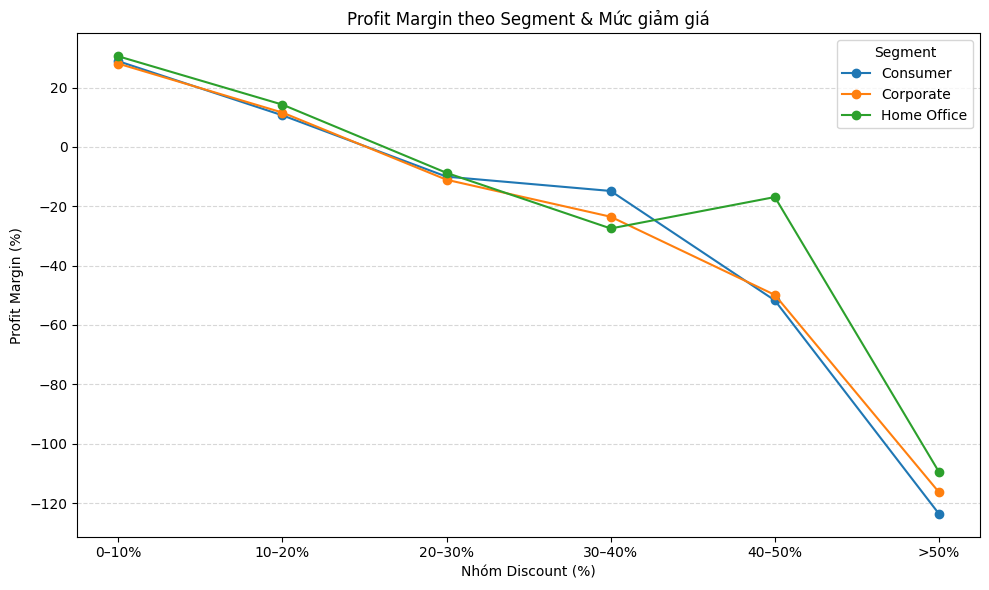

In [ ]:
# Vẽ biểu đồ đường Profit Margin theo Segment và Mức giảm giá
plt.figure(figsize=(10,6))
for seg in segment_discount['Segment'].unique():
    subset = segment_discount[segment_discount['Segment'] == seg]
    plt.plot(subset['Discount_Group'], subset['Profit_Margin_%'], marker='o', label=seg)

plt.title("Profit Margin theo Segment & Mức giảm giá")
plt.xlabel("Nhóm Discount (%)")
plt.ylabel("Profit Margin (%)")
plt.legend(title="Segment")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


TỔNG QUAN:

Mức độ ảnh hưởng của giảm giá (Discount) tới biên lợi nhuận (Profit Margin) trong từng phân khúc khách hàng (Segment): Khi tỷ lệ giảm giá tăng, biên lợi nhuận giảm mạnh ở tất cả các phân khúc, và đặc biệt phân khúc Consumer là nhạy cảm nhất với chiết khấu cao, dễ chuyển sang lỗ.

CHI TIẾT:
- Tất cả các đường biểu diễn (Consumer - Corporate - Home Office) đều có độ dốc âm mạnh, thể hiện mối quan hệ nghịch biến mạnh giữa Discount và Profit Margin.
- Từ ngưỡng >20% chiết khấu, biên lợi nhuận của cả ba phân khúc bắt đầu âm.
- Consumer có đường dốc giảm nhanh nhất, thể hiện nhạy cảm cao nhất. Còn Corporate và Home Office giảm chậm hơn một chút, nhờ cấu trúc giá bán cao hơn và ít chịu chiết khấu sâu.

KẾT LUẬN:
- Phân khúc nhạy cảm nhất với giảm giá: Consumer - lợi nhuận sụt giảm nhanh nhất khi áp dụng giảm giá trên 20%, thậm chí lỗ nặng (>50% Discount) do đặc thù khách hàng cá nhân dễ bị tác động bởi khuyến mãi và giá thấp.
- Phân khúc ổn định nhất: Home Office - duy trì được lợi nhuận dương lâu hơn, biên lợi nhuận vẫn tốt ở mức chiết khấu thấp (≤20%).
- Ảnh hưởng tổng quát: Discount >20% làm tất cả phân khúc bắt đầu lỗ. Mức >50% khiến Profit Margin âm hơn 100%, tức là mất vốn.